In [2]:
import import_ipynb
from search import *
import cv2
import matplotlib.pyplot as plt
import numpy as np

score_ls = search('./score')

def make_list(score_list):
    # 스코어 이미지를 2차원 배열화.
    ls = [[] for _ in range(100)]
    index = -1
    for data in score_list:
        if data[-5] == '0':
            index += 1
        ls[index].append(data)

    ls = list(filter(None, ls))
    
    return ls

def get_each_number(data):
    # 이미지 샤프닝을 위한 배열
    sharpening_mask1 = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    
    image = cv2.imread(data)
    
    # 이미지 샤프닝
    image = cv2.filter2D(image, -1, sharpening_mask1)
    H, W, C = image.shape
    
    # 이미지 그레이 스케일 변환
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 이미지 스레스 홀딩
    img_thresh = cv2.adaptiveThreshold(img_gray, maxValue = 255.0,
                                 adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                thresholdType = cv2.THRESH_BINARY_INV,
                                   blockSize = 29, C = 3)
    
    # 윤곽선 찾기
    contours, _ = cv2.findContours(
                img_thresh,
                mode = cv2.RETR_LIST,
                method = cv2.CHAIN_APPROX_SIMPLE
                )

    # 이미지와 똑같은 크기의 numpy 배열에 윤곽선 그리기
    temp_result = np.zeros((H,W,C), dtype = np.uint8)
    cv2.drawContours(temp_result, contours = contours, 
                contourIdx = -1, color = (255,255,255))

    # 윤곽선을 사각형으로 구역화 하기
    contours_dict = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(temp_result, pt1 = (x,y), pt2 = (x+w, y+h),
                             color = (255,255,255), thickness = 1)
        contours_dict.append({
            'contour' : contour,
            'x' : x,
            'y' : y,
            'w' : w,
            'h' : h,
            'cx' : x + (w/2),
            'cy' : y + (h/2)
        })

#     plt.figure(figsize=(6,5))
#     plt.imshow(temp_result)

    # 숫자만을 위한 최소 기준치
    MIN_AREA = 800
    MAX_AREA = 3500
    MIN_WIDTH, MIN_HEIGHT = 10, 40
    MIN_RATIO, MAX_RATIO = 0.1, 1.2

    possible_contours = []

    cnt = 0

    for d in contours_dict:
        area = d['w'] * d['h']
        ratio = d['w'] / d['h']
        if (area > MIN_AREA and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT 
            and MIN_RATIO < ratio < MAX_RATIO and area < MAX_AREA):
            d['idx'] = cnt
            cnt += 1
            possible_contours.append(d)

    # 이미지와 똑같은 크기의 numpy에 숫자만 구역화하기
    temp_result = np.zeros((H, W, C), dtype = np.uint8)
    for d in possible_contours:
        cv2.rectangle(temp_result, pt1 = (d['x'], d['y']), pt2 = (d['x']+d['w'], d['y']+d['h']),
                    color = (255,255,255), thickness = 1)
#     plt.figure(figsize=(6,5))
#     plt.imshow(image)
#     plt.figure(figsize=(6,5))
#     plt.imshow(temp_result)


    # x 좌푯값 기준으로 정렬하기
    plate_img = []

    for i in range(len(possible_contours)):
        for j in range(i, len(possible_contours)):
            tmp = possible_contours[i]
            if possible_contours[i]['x'] > possible_contours[j]['x']:
                possible_contours[i] = possible_contours[j]
                possible_contours[j] = tmp

    # 중복 제거 : 중앙점을 기준으로
    temp = []
    for data in possible_contours:
        if len(temp) == 0:
            temp.append(data)
            continue

        if data['cx'] - temp[-1]['cx'] > 10:
            temp.append(data)

    possible_contours = temp

    for d in possible_contours:
        pw = d['w']
        ph = d['h']
        pcx = d['cx']
        pcy = d['cy']
        img_cropped = cv2.getRectSubPix(
            image,
            patchSize = (pw, ph),
            center = (pcx, pcy)
            )
        img_cropped = cv2.resize(img_cropped, (20,20))
        plate_img.append(img_cropped)

#     for d in plate_img:
#         plt.figure(figsize=(4,4))
#         plt.imshow(d)
    return plate_img

In [169]:
# path = './numbers/'
# index = 0
# for scores in ls:
#     sec = 0
#     for data in scores:
#         temp = get_each_number(data)
#         cnt = 0
#         for i in temp:
#             cv2.imwrite(path + str(index) + '_' + str(sec) + '_' + str(cnt) + '.jpg', i)
#             cnt += 1
#         sec += 1
#     index += 1

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_26432\1040073349.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(1,1))


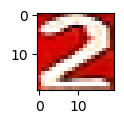

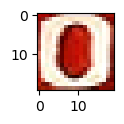

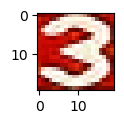

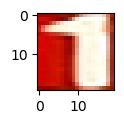

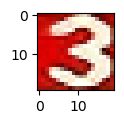

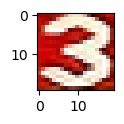

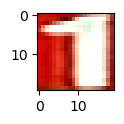

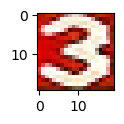

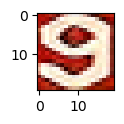

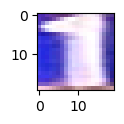

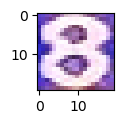

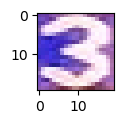

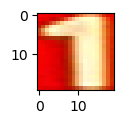

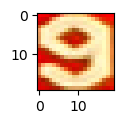

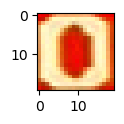

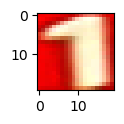

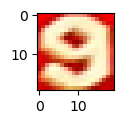

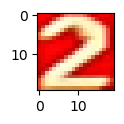

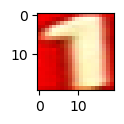

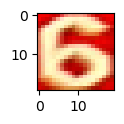

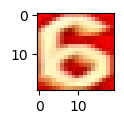

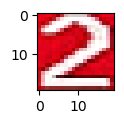

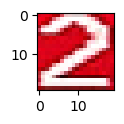

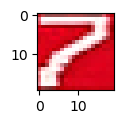

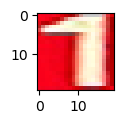

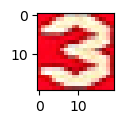

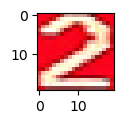

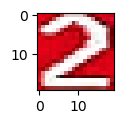

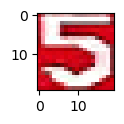

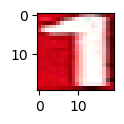

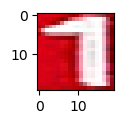

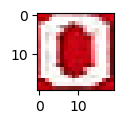

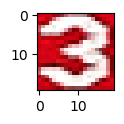

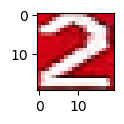

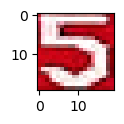

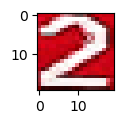

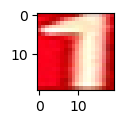

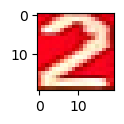

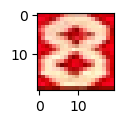

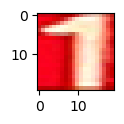

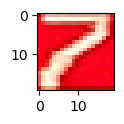

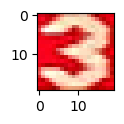

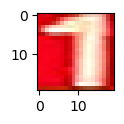

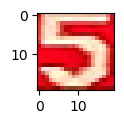

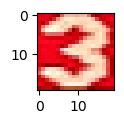

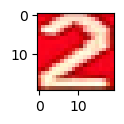

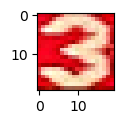

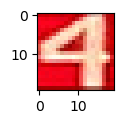

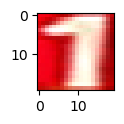

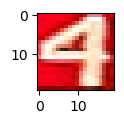

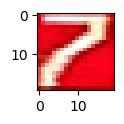

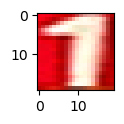

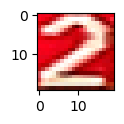

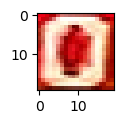

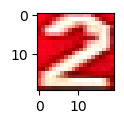

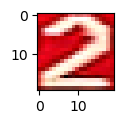

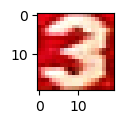

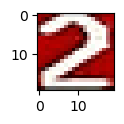

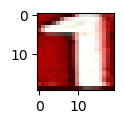

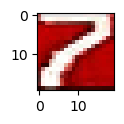

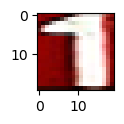

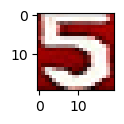

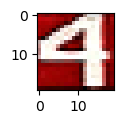

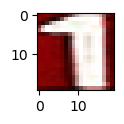

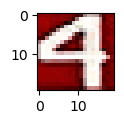

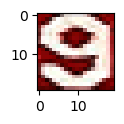

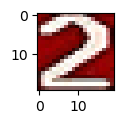

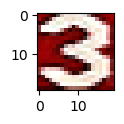

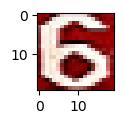

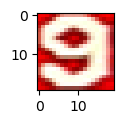

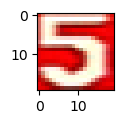

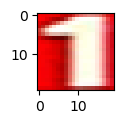

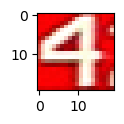

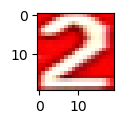

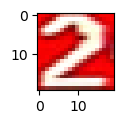

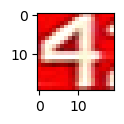

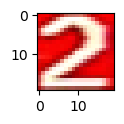

In [171]:
# for scores in ls:
#     for data in scores:
#         temp = get_each_number(data)
#         for i in temp:
#             plt.figure(figsize=(1,1))
#             plt.imshow(i)